# Network Analysis of Paraguayan Beef Exporters

### Section 1 - Load Data and Initialize Network

In [4]:
import pandas as pd
import networkx as nx
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load edge list and node attributes
# These files were previously generated from export transaction data
edges_df = pd.read_csv("beef_coexport_edges.csv")
nodes_df = pd.read_csv("beef_export_nodes.csv")

In [8]:
# Initialize undirected graph
# Each edge represents a co-occurrence of two exporters targeting the same destination market in a given year
G = nx.Graph()

# Add edges with attributes
for _, row in edges_df.iterrows():
    G.add_edge(
        row['source'],
        row['target'],
        weight=row['weight'],
        year=row['year'],
        country=row['country']
    )

In [10]:
# Basic overview
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 20
Number of edges: 131


### Section 2 - Global Network description

In [18]:
# Compute basic structural metrics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density of the network: {density:.4f}")

Number of nodes: 20
Number of edges: 131
Density of the network: 0.6895


In [20]:
# Compute average degree (mean number of connections per node)
degrees = [deg for _, deg in G.degree()]
avg_degree = np.mean(degrees)
print(f"Average degree: {avg_degree:.2f}")

Average degree: 13.10


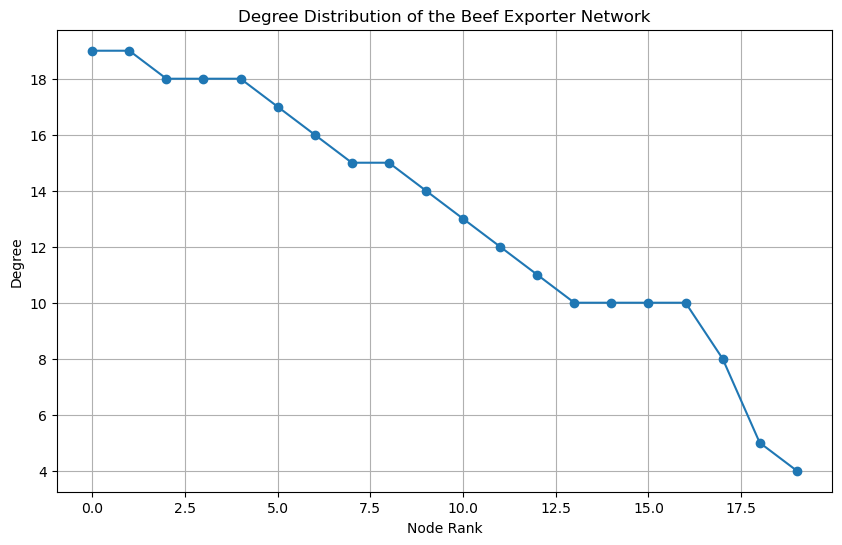

In [22]:
# Plot degree distribution
# This gives an overview of how exporter connectivity is distributed in the network
degree_sequence = sorted(degrees, reverse=True)
plt.figure(figsize=(10, 6))
plt.plot(degree_sequence, marker='o')
plt.title('Degree Distribution of the Beef Exporter Network')
plt.xlabel('Node Rank')
plt.ylabel('Degree')
plt.grid(True)
plt.show()

### Section 3 - Centrality measures

In [24]:
# Compute Degree Centrality
# Reflects the number of direct connections each exporter has
degree_centrality = nx.degree_centrality(G)

# Helper function: extract top N nodes by centrality score
def top_n_centrality(centrality_dict, n=10):
    sorted_centrality = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_centrality[:n]

# Top 10 exporters by degree centrality
print("Top 10 Exporters by Degree Centrality:")
top_10_degree = top_n_centrality(degree_centrality)
for i, (firm, score) in enumerate(top_10_degree, 1):
    print(f"{i}. {firm}: {score:.4f}")

Top 10 Exporters by Degree Centrality:
1. COOPERATIVA CHORTITZER: 1.0000
2. MINERVA: 1.0000
3. FRIGORIFICO CONCEPCION: 0.9474
4. FRIGORIFICO GUARANI: 0.9474
5. COOPERATIVA FERNHEIM: 0.9474
6. COOPERATIVA NEULAND: 0.8947
7. TRIPERA PARAGUAYA (TRIPAR): 0.8421
8. JBS: 0.7895
9. FRIGORIFICO NORTE: 0.7895
10. HAWKER INTERNATIONAL: 0.7368


In [26]:
# Compute Betweenness Centrality (weighted)
# Identifies firms acting as bridges between others
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

print("\nTop 10 Exporters by Betweenness Centrality:")
top_10_betweenness = top_n_centrality(betweenness_centrality)
for i, (firm, score) in enumerate(top_10_betweenness, 1):
    print(f"{i}. {firm}: {score:.6f}")


Top 10 Exporters by Betweenness Centrality:
1. SWEET: 0.549708
2. FRIGORIFICO GUARANI: 0.327485
3. COOPERATIVA CHORTITZER: 0.181287
4. YLF: 0.134503
5. FRIGORIFICO ALL FOOD: 0.128655
6. HAWKER INTERNATIONAL: 0.128655
7. FRIGORIFICO CONCEPCION: 0.122807
8. FRIGOMEAT: 0.111111
9. VIVA MEAT: 0.105263
10. TRIPERA PARAGUAYA (TRIPAR): 0.093567


In [28]:
# Compute Eigenvector Centrality (weighted)
# Measures influence based on connections to other well-connected nodes
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=500)

print("\nTop 10 Exporters by Eigenvector Centrality:")
top_10_eigenvector = top_n_centrality(eigenvector_centrality)
for i, (firm, score) in enumerate(top_10_eigenvector, 1):
    print(f"{i}. {firm}: {score:.6f}")


Top 10 Exporters by Eigenvector Centrality:
1. MINERVA: 0.552591
2. HAWKER INTERNATIONAL: 0.425743
3. TRANS BUSINESS: 0.401859
4. FRIGORIFICO CONCEPCION: 0.357510
5. JBS: 0.219853
6. FRIGORIFICO NORTE: 0.176273
7. TRIPERA PARAGUAYA (TRIPAR): 0.169493
8. SANEGO: 0.156200
9. COOPERATIVA CHORTITZER: 0.148800
10. COOPERATIVA FERNHEIM: 0.144743


In [32]:
# Compute Closeness Centrality
# Indicates how close a firm is to all others in terms of shortest paths
closeness_centrality = nx.closeness_centrality(G)

print("\nTop 10 Exporters by Closeness Centrality:")
top_10_closeness = top_n_centrality(closeness_centrality)
for i, (firm, score) in enumerate(top_10_closeness, 1):
    print(f"{i}. {firm}: {score:.6f}")


Top 10 Exporters by Closeness Centrality:
1. COOPERATIVA CHORTITZER: 1.000000
2. MINERVA: 1.000000
3. FRIGORIFICO CONCEPCION: 0.950000
4. FRIGORIFICO GUARANI: 0.950000
5. COOPERATIVA FERNHEIM: 0.950000
6. COOPERATIVA NEULAND: 0.904762
7. TRIPERA PARAGUAYA (TRIPAR): 0.863636
8. JBS: 0.826087
9. FRIGORIFICO NORTE: 0.826087
10. HAWKER INTERNATIONAL: 0.791667


### Section 4 - Community Detection (Louvain Method)

In [36]:
# Apply Louvain algorithm to detect modular communities
# This method identifies groups of exporters with denser internal connections
partition = community_louvain.best_partition(G, weight='weight')

In [38]:
# Convert the partition result to a DataFrame
df_louvain = pd.DataFrame.from_dict(partition, orient='index', columns=['louvain_community']).reset_index()
df_louvain.rename(columns={'index': 'Id'}, inplace=True)

# Standardize exporter identifiers
df_louvain['Id'] = df_louvain['Id'].str.strip().str.upper()

In [40]:
# Count number of distinct communities
num_communities = df_louvain['louvain_community'].nunique()
print(f"Number of Louvain communities detected: {num_communities}")

Number of Louvain communities detected: 3


In [42]:
# Display member firms per community
for c in sorted(df_louvain['louvain_community'].unique()):
    print(f"\nCommunity {c}:")
    print(df_louvain[df_louvain['louvain_community'] == c]['Id'].tolist())


Community 0:
['MINERVA', 'HAWKER INTERNATIONAL', 'FRIGORIFICO NORTE', 'SANEGO', 'TRANS BUSINESS']

Community 1:
['FRIGORIFICO CONCEPCION', 'FRIGORIFICO SAN PEDRO', 'TRIPERA PARAGUAYA (TRIPAR)', 'VPR FOOD IMPORT - EXPORT', 'TERRANOSTRA']

Community 2:
['COOPERATIVA CHORTITZER', 'FRIGORIFICO GUARANI', 'JBS', 'COOPERATIVA FERNHEIM', 'COOPERATIVA NEULAND', 'FRIGORIFICO ALL FOOD', 'VIVA MEAT', 'SWEET', 'FRIGOMEAT', 'YLF']


### Section 5 - Attributes analysis

In [47]:
# Load node-level economic attributes
df_attrs = pd.read_csv("beef_export_nodes.csv")
print(df_attrs.columns)

Index(['Id', 'total_fob_value', 'total_volume', 'total_land_use',
       'transnational'],
      dtype='object')


In [49]:
# Drop any pre-existing community assignment (if present)
df_attrs = df_attrs.drop(columns=['louvain_community'], errors='ignore')

In [51]:
# Merge Louvain community assignment into attribute table
df_merged = df_attrs.merge(df_louvain, on="Id", how="left")
print(df_merged.columns)

Index(['Id', 'total_fob_value', 'total_volume', 'total_land_use',
       'transnational', 'louvain_community'],
      dtype='object')


In [53]:
# Descriptive statistics by Louvain community
group_stats = df_merged.groupby('louvain_community').agg(
    num_enterprises = ('Id', 'count'),
    avg_fob_value = ('total_fob_value', 'mean'),
    median_fob_value = ('total_fob_value', 'median'),
    total_fob_value = ('total_fob_value', 'sum'),
    avg_land_use = ('total_land_use', 'mean'),
    median_land_use = ('total_land_use', 'median'),
    total_land_use = ('total_land_use', 'sum')
).reset_index().sort_values(by='total_fob_value', ascending=False)

# Configure display: suppress scientific notation and show thousand separators
pd.options.display.float_format = '{:,.0f}'.format

display(group_stats)

,louvain_community,num_enterprises,avg_fob_value,median_fob_value,total_fob_value,avg_land_use,median_land_use,total_land_use
2,2,10,"277,634,436","193,224,879","2,776,344,362","837,789","378,071","8,377,894"
0,0,5,"493,165,439","24,897,844","2,465,827,197","1,910,132","87,526","9,550,662"
1,1,5,"357,120,187","92,394,343","1,785,600,933","865,861","47,311","4,329,306"


In [55]:
# Restore default pandas float display format
pd.reset_option('display.float_format')

In [57]:
# Count transnational firms by Louvain community
trans_counts = df_merged.groupby(['louvain_community', 'transnational']).agg(
    num_enterprises = ('Id', 'count')
).reset_index()

# Pivot table to compare community composition
trans_pivot = trans_counts.pivot(index='louvain_community', columns='transnational', values='num_enterprises').fillna(0)

# Add total and proportion of transnational firms
trans_pivot['total'] = trans_pivot.sum(axis=1)
trans_pivot['prop_transnational'] = trans_pivot.get('Oui', 0) / trans_pivot['total']

display(trans_pivot)

transnational,Non,Oui,total,prop_transnational
louvain_community,,,,
0,3.0,2.0,5.0,0.4
1,5.0,0.0,5.0,0.0
2,8.0,2.0,10.0,0.2


In [61]:
# Compute PageRank for each node
pagerank_dict = nx.pagerank(G, weight='weight')
print(pagerank_dict)
# Convert to DataFrame
df_pagerank = pd.DataFrame.from_dict(pagerank_dict, orient='index', columns=['pagerank']).reset_index()
df_pagerank.rename(columns={'index': 'Id'}, inplace=True)

# Merge PageRank into main node dataset
df_merged = df_merged.merge(df_pagerank, on='Id', how='left')


{'COOPERATIVA CHORTITZER': 0.05215825582226452, 'FRIGORIFICO CONCEPCION': 0.10468249679580154, 'FRIGORIFICO GUARANI': 0.040206203672693244, 'FRIGORIFICO SAN PEDRO': 0.03385608560087638, 'JBS': 0.07492735773777957, 'COOPERATIVA FERNHEIM': 0.047918137594876044, 'COOPERATIVA NEULAND': 0.046679154532024356, 'FRIGORIFICO ALL FOOD': 0.0285327560028863, 'MINERVA': 0.1595789707635896, 'HAWKER INTERNATIONAL': 0.08951890639211155, 'TRIPERA PARAGUAYA (TRIPAR)': 0.06688015707512981, 'VIVA MEAT': 0.011185655868651573, 'SWEET': 0.011624499519970459, 'FRIGORIFICO NORTE': 0.04879740363343279, 'FRIGOMEAT': 0.019548854798263057, 'VPR FOOD IMPORT - EXPORT': 0.018539731944499073, 'YLF': 0.012005387720158918, 'TERRANOSTRA': 0.012492779771719226, 'SANEGO': 0.04117289840293554, 'TRANS BUSINESS': 0.07969430635033675}


In [63]:
# Compute modularity score of the detected community structure
modularity_value = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularity: {modularity_value:.4f}")

Modularity: 0.1266


### Section 6 - Quick Visualization and Export for Gephi

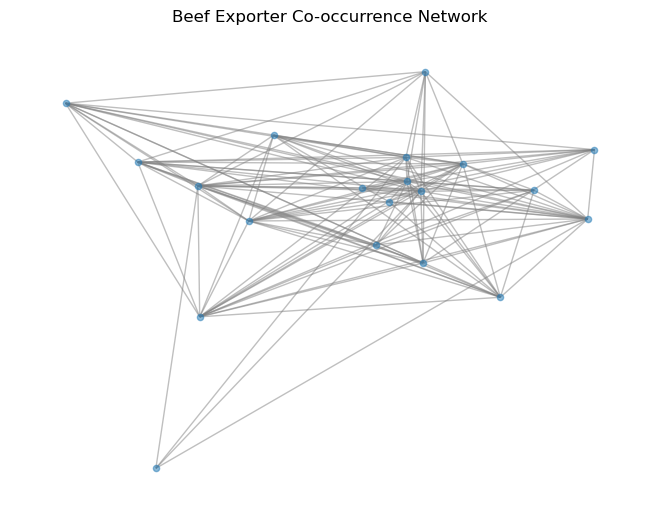

In [67]:
# Basic network visualization (optional, for quick inspection)
nx.draw(G, node_size=20, edge_color='gray', alpha=0.5)
plt.title("Beef Exporter Co-occurrence Network")
plt.show()

In [ ]:
# Select key node attributes for export to Gephi
nodes_gephi = df_merged[[
    'Id',
    'transnational',
    'total_fob_value',
    'total_land_use',
    'louvain_community',
    'pagerank'
]]

# Export node attributes to CSV
nodes_gephi.to_csv("nodes_gephi_beef.csv", index=False)